# Analysis of the Usage of Bayesian Approaches from 2020 Kaggle ML and DS Survey Responses
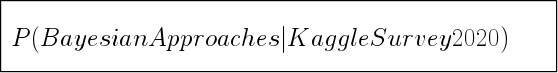

# Motivation

We are two friends that have used Bayesian approaches in our research. Specifically, our research uses a lot of reasoning on Bayesian networks and ideas developed by the Turing Award winner, Judea Pearl. Since Bayesian approaches can range from the usage of Naive Bayes to sophisticated AI algorithms using counterfactuals on Bayesian networks, we wanted to investigate on which side of the spectrum do Kaggle users lean. Spoiler alert, we do use Bayesian approaches in our analysis! 

# Notebook Content
* [Importing the Required Libraries and Functions](#Part0)
* [Exploratory Data Analysis](#Part1): We examine what fraction of people with certain age, degree, salary, title, or experience use Bayesian Approaches. 
* [Using Bayesian Models to Analyze Bayesian Usage](#Part2)
    * [Feature Extraction](#Part2-1): We extract features from the data that are related to our analysis. 
    * [Model Training](#Part2-2): We create a Bayesian model that predicts whether a Kaggler uses Bayesian approaches or not. 
    * [Revisiting Feature Extraction](#Part2-3): We use a Bayesian approach to choose the most informative features for the model.
* [Comparing the Bayesian Model Performance with Other Methods](#Part3): We compare our simple Bayesian model with other methods, such as logistic regression, SVM, and Decision Tree classifiers.
* [Eliminating AI Bias from the Model](#Part4): We eliminate some features that might make our model biased towards some protected categories. 
* [Concluding Remarks](#Part5)
* [References](#Part6)

# <a class="anchor" id="Part0"></a> Importing the Required Libraries and Functions 

In [ ]:
# Import all the libraries we need
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 5000)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB,ComplementNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

from scipy import stats, linalg
import networkx as nx
from sklearn.preprocessing import StandardScaler
from itertools import chain, combinations
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [ ]:
# helper methods from Kaggle EDA

def load_csv(base_dir,file_name):
    """Loads a CSV file into a Pandas DataFrame"""
    file_path = os.path.join(base_dir,file_name)
    df = pd.read_csv(file_path,low_memory=False)
    return df

def count_then_return_percent(dataframe,column_name):
    '''
    A helper function to return value counts as percentages.
    
    It has the following dependencies:
    numpy: 1.18.5; pandas: 1.1.3

    import numpy as np 
    import pandas as pd 
    '''
    
    counts = dataframe[column_name].value_counts(dropna=False)
    percentages = round(counts*100/(dataframe[column_name].count()),1)
    return percentages

def count_then_return_percent_for_multiple_column_questions(dataframe,list_of_columns_for_a_single_question,dictionary_of_counts_for_a_single_question):
    '''
    A helper function to convert counts to percentages.
    
    It has the following dependencies:
    numpy: 1.18.5; pandas: 1.1.3

    import numpy as np 
    import pandas as pd 
    '''
    
    df = dataframe
    subset = list_of_columns_for_a_single_question
    df = df[subset]
    df = df.dropna(how='all')
    total_count = len(df) 
    dictionary = dictionary_of_counts_for_a_single_question
    for i in dictionary:
        dictionary[i] = round(float(dictionary[i]*100/total_count),1)
    return dictionary 

def create_dataframe_of_counts(dataframe,column,rename_index,rename_column,return_percentages=False):
    '''
    A helper function to create a dataframe of either counts 
    or percentages, for a single multiple choice question.
    
    It has the following dependencies: 
    numpy: 1.18.5; pandas: 1.1.3
    
    import numpy as np 
    import pandas as pd  
    '''
    df = dataframe[column].value_counts().reset_index() 
    if return_percentages==True:
        df[column] = (df[column]*100)/(df[column].sum())
    df = pd.DataFrame(df) 
    df = df.rename({'index':rename_index, 'Q3':rename_column}, axis='columns')
    return df

def sort_dictionary_by_percent(dataframe,list_of_columns_for_a_single_question,dictionary_of_counts_for_a_single_question): 
    ''' 
    A helper function that can be used to sort a dictionary.
    
    It is an adaptation of a similar function
    from https://www.kaggle.com/sonmou/what-topics-from-where-to-learn-data-science.
    
    It has the following dependencies:
    numpy: 1.18.5; pandas: 1.1.3

    import numpy as np 
    import pandas as pd 
    '''
    dictionary = count_then_return_percent_for_multiple_column_questions(dataframe,
                                                                list_of_columns_for_a_single_question,
                                                                dictionary_of_counts_for_a_single_question)
    dictionary = {v:k    for(k,v) in dictionary.items()}
    list_tuples = sorted(dictionary.items(), reverse=False) 
    dictionary = {v:k for (k,v) in list_tuples}   
    return dictionary

def plotly_bar_chart(response_counts,title,y_axis_title,orientation):
    '''
    This function creates a bar chart.
    
    It has the following dependencies:
    plotly express: 0.4.1
    
    import plotly.express as px
    '''
    response_counts_series = pd.Series(response_counts)
    fig = px.bar(response_counts_series,
             labels={"index": '',"value": y_axis_title},
             text=response_counts_series.values,
             orientation=orientation,)
    fig.update_layout(showlegend=False,
                      title={'text': title,
                             'y':0.95,
                             'x':0.5,})
    fig.show()

def plotly_choropleth_map(df, column, title, max_value):
    '''
    This function creates a choropleth map.
    
    It has the following dependencies:
    plotly express: 0.4.1
    
    import plotly.express as px
    '''
    fig = px.choropleth(df, 
                    locations = 'country',  
                    color = column,
                    locationmode = 'country names', 
                    color_continuous_scale = 'viridis',
                    title = title,
                    range_color = [0, max_value])
    fig.update(layout=dict(title=dict(x=0.5)))
    fig.show()
        
def plotly_bar_chart_with_x_axis_limit(response_counts,title,y_axis_title,orientation,limit_for_axis):
    '''
    A slightly modified version of plotly_bar_chart().
    
    It has the following dependencies:
    plotly express: 0.4.1
    
    import plotly.express as px
    '''
    response_counts_series = pd.Series(response_counts)
    fig = px.bar(response_counts_series,
             labels={"index": '',"value": y_axis_title},
             text=response_counts_series.values,
             orientation=orientation,)
    fig.update_xaxes(range=[0, limit_for_axis])
    fig.update_layout(showlegend=False,
                      title={'text': title,
                             'y':0.95,
                             'x':0.5,})
    fig.show()

In [ ]:
# Load the data

base_dir = '/kaggle/input/'
file_name = 'kaggle_survey_2020_responses.csv'
survey_df = load_csv(base_dir,file_name)

# Get the responses only
responses_df = survey_df[1:]

# <a class="anchor" id="Part1"></a> Exploratory Data Analysis 

We are interested in the subpopulation that uses Bayesian Aproaches (BA). 
Let's get some ideas about who that subpopulation is.
The spectrum of Bayesian approaches is wide. 
Both Naive Bayes as well as sophisticated graphical models and counterfactual reasoning are in that spectrum. 
So on which end of the spectrum are our Bayesian Kaggle users? 

In [ ]:
bayesian_df = survey_df[survey_df['Q17_Part_4']=='Bayesian Approaches']
ba_responses_df = bayesian_df[1:]

### Let's see the usage of BA per country (normalized by total number of responses per country).

In [ ]:
ba_responses_per_country_df = create_dataframe_of_counts(bayesian_df,'Q3','country','# of respondents',return_percentages=False)
ba_percentages_per_country_df = create_dataframe_of_counts(bayesian_df,'Q3','country','% of respondents',return_percentages=True)

In [ ]:
responses_per_country_df = create_dataframe_of_counts(survey_df,'Q3','country','# of respondents',return_percentages=False)
merged_res = ba_responses_per_country_df.merge(responses_per_country_df, how='inner', on='country')
ba_responses_per_country_df['normalized'] = merged_res['# of respondents_x'].values/merged_res['# of respondents_y'].values

In [ ]:
plotly_choropleth_map(ba_responses_per_country_df, 
                       'normalized', 
                       'Proportion of Bayesian usage per country (2020 Kaggle DS & ML Survey)',
                        max_value = np.max(ba_responses_per_country_df.normalized.values)+0.02)

print('Note that countries with less than 50 responses were replaced with the country name "other" (which does not show up on this map)')

Interestingly, it seems that in the Americas, there is higher usage of Bayesian approaches!

### Let's check whether BAs are more used by people with higher education.

In [ ]:
question_name = 'Q4'
responses_in_order = ["I prefer not to answer","No formal education past high school",
                      "Some college/university study without earning a bachelor’s degree",
                      "Bachelor’s degree","Master’s degree","Doctoral degree","Professional degree"]
sorted_percentages = count_then_return_percent(ba_responses_df,question_name)[responses_in_order]
title_for_chart = 'Most Common Degree Type'
title_for_y_axis = '% of respondents'
orientation_for_chart = 'v'
  
plotly_bar_chart(response_counts=sorted_percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

While the distribution of degrees in the 'BA' subpopulation is similar to the degree distribution in the population, let's ask a bit of a different question. 
For each educational group, what is the fraction of people using BA?

In [ ]:
question_name = 'Q4'
responses_in_order = ["I prefer not to answer","No formal education past high school",
                      "Some college/university study without earning a bachelor’s degree",
                      "Bachelor’s degree","Master’s degree","Doctoral degree","Professional degree"]

num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df['Q4'] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df['Q4'] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)
mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})

fig = px.line(mini_df, x='responses', y='fractions', title='Fraction of people using BA, given their degree')
fig.show()

So people with Doctoral Degree use BA the most! Notice they use it 7% more than people with MS!

### Let's do the same analysis with respect to gender, bucketed age and the size of the company people work for. 

In [ ]:
#Same analysis as in 2, wrt gender 
question_name = 'Q2'
responses_in_order = ["Man", "Woman", "Nonbinary", "Prefer not to say", "Prefer to self-describe"]

num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of gender')
fig.show()

In [ ]:
#Same analysis as in 2, wrt bucketed age 
question_name = 'Q1'
responses_in_order = ["18-21","22-24", "25-29", "30-34", "35-39","40-44", "45-49", "50-54","55-59","60-69"]

num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of age')
fig.show()

Wow, almost as if, the older you are, the more likely you use BA! 

In [ ]:
#Same analysis as in 2, wrt company size
question_name = 'Q20'
responses_in_order = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees"]

num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of company size')
fig.show()

So it's used almost equally across different sizes of companies. So if we weight the fractions by the percentages of population presense of each of the company size buckets 

In [ ]:
question_name = 'Q20'
responses_in_order = ['0-49 employees',
                      '50-249 employees','250-999 employees',
                      "1000-9,999 employees"]
sorted_percentages = count_then_return_percent(responses_df,question_name)[responses_in_order]

mini_df['weights'] = sorted_percentages
mini_df.fillna(0, inplace=True)
mini_df['weighted'] = sorted_percentages.values/100.0 * mini_df['fractions'].values

fig = px.line(mini_df, x='responses', y='weighted', title='Usage of BA, as a weighted fraction of company size')
fig.show()

Looking at the weighted fraction, it seems BA are used the most in small companies and equally across bigger companies.

### Now let's do the same analysis with respect to years of programming experience, machine learning experience, yearly compensation (salary), and the job title. 

In [ ]:
#programming experience and usage of BA
question_name = 'Q6'
responses_in_order = ['I have never written code',
                      '< 1 years','1-2 years','3-5 years',
                      '5-10 years','10-20 years','20+ years']


num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of Programming Experience')
fig.show()

It seems the more programming experience you have, the more you use BA!

In [ ]:
#ML experience and usage of BA
question_name = 'Q15'
responses_in_order = ['I do not use machine learning methods',
                      'Under 1 year','1-2 years','2-3 years',
                      '3-4 years','4-5 years','5-10 years',
                     '10-20 years', '20 or more years']

num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of ML Experience')
fig.show()

Again, the more ML experience one has, the more BA one uses! 

In [ ]:
#Salary and usage of BA
question_name = 'Q24'
responses_in_order = ['$0-999',
                        '1,000-1,999',
                        '2,000-2,999',
                        '3,000-3,999',
                        '4,000-4,999',
                        '5,000-7,499',
                        '7,500-9,999',
                        '10,000-14,999',
                        '15,000-19,999',
                        '20,000-24,999',
                        '25,000-29,999',
                        '30,000-39,999',
                        '40,000-49,999',
                        '50,000-59,999',
                        '60,000-69,999',
                        '70,000-79,999',
                        '80,000-89,999',
                        '90,000-99,999',
                        '100,000-124,999',
                        '125,000-149,999',
                        '150,000-199,999',
                        '200,000-249,999',
                        '250,000-299,999',
                        '300,000-500,000',
                        '> $500,000']
num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction salary')
fig.show()

Some of the top earners use BA!

In [ ]:
# Let's look at the usage of Bayesian approaches as a fraction of title


#Salary and usage of BA
question_name = 'Q5'
responses_in_order = [ 'Student', 'Data Engineer', 'Software Engineer', 'Data Scientist',
                        'Data Analyst', 'Research Scientist', 'Other',
                        'Currently not employed', 'Statistician',
                        'Product/Project Manager', 'Machine Learning Engineer',
                        'Business Analyst', 'DBA/Database Engineer']
num_responses_in_order = []
num_responses_in_order_ba = []

for r in responses_in_order:
    
    temp = survey_df[survey_df[question_name] == r]
    num_responses_in_order.append(temp.shape[0])
    
    temp_ba = survey_df[(survey_df[question_name] == r) & (survey_df['Q17_Part_4']=='Bayesian Approaches')]
    num_responses_in_order_ba.append(temp_ba.shape[0])
    
fractions = np.asarray(num_responses_in_order_ba)/np.asarray(num_responses_in_order)

mini_df = pd.DataFrame({'responses': responses_in_order, 'fractions': fractions})
fig = px.line(mini_df, x='responses', y='fractions', title='Usage of BA, as a fraction of title')
fig.show()

Data scientists, reseach scientists and statisticians have the highest number of people using Bayesian approaches. 

# <a class="anchor" id="Part2"></a> Using Bayesian Models to Analyze Bayesian Usage 
    
**Now let's use some Bayesian approaches to study Bayesian usage!**

We will start by a simple Naive Bayes and then we will also use some graphical model techniques :) 
We're gonna make a model predicting whether a Kaggler uses BA or doesn't. We'll use Naive Bayes for starters :) 

In [ ]:
target = responses_df['Q17_Part_4']=='Bayesian Approaches'
print(target.value_counts())

## <a class="anchor" id="Part2"></a> Feature Extraction 
Let's create the features.
* Age

In [ ]:
le_age = LabelEncoder()
age_feature = le_age.fit_transform(survey_df['Q1'].values[1:]) # to remove the first entry which is the question
print(le_age.classes_)

* Gender

In [ ]:
le_gender = LabelEncoder()
gender_feature = le_gender.fit_transform(survey_df['Q2'].values[1:]) # to remove the first entry which is the question
print(le_gender.classes_)

* Educational Level

In [ ]:
le_degree = LabelEncoder()
survey_df['Q4'].fillna(value='NA', inplace=True)
degree_feature = le_degree.fit_transform(survey_df['Q4'].values[1:]) # to remove the first entry which is the question
print(le_degree.classes_)

* Company Size

In [ ]:
le_compsize = LabelEncoder()
survey_df['Q20'].fillna(value='NA', inplace=True)
compsize_feature = le_compsize.fit_transform(survey_df['Q20'].values[1:]) # to remove the first entry which is the question
print(le_compsize.classes_)

* Programming Experience

In [ ]:
le_prgexp = LabelEncoder()
survey_df['Q6'].fillna(value='NA', inplace=True)
prgexp_feature = le_prgexp.fit_transform(survey_df['Q6'].values[1:]) # to remove the first entry which is the question
print(le_prgexp.classes_)

* Machine Learning Experience

In [ ]:
le_mlexp = LabelEncoder()
survey_df['Q15'].fillna(value='NA', inplace=True)
mlexp_feature = le_mlexp.fit_transform(survey_df['Q15'].values[1:]) # to remove the first entry which is the question
print(le_mlexp.classes_)

* Salary

In [ ]:
le_salary = LabelEncoder()
survey_df['Q24'].fillna(value='NA', inplace=True)
salary_feature = le_salary.fit_transform(survey_df['Q24'].values[1:]) # to remove the first entry which is the question
print(le_salary.classes_)

* Job Title

In [ ]:
le_title = LabelEncoder()
survey_df['Q5'].fillna(value='NA', inplace=True)
title_feature = le_title.fit_transform(survey_df['Q5'].values[1:]) # to remove the first entry which is the question
print(le_title.classes_)

Here we combine all the different features we extracted from the available data. 

In [ ]:
nb_df = pd.DataFrame({'Age': age_feature, 
                      'Gender': gender_feature, 
                      'Degree': degree_feature, 
                      'CompanySize': compsize_feature, 
                      'ProgrammingExp': prgexp_feature, 
                      'MLExp': mlexp_feature, 
                      'Salary': salary_feature, 
                      'Title': title_feature,
                      'Target': target})

In [ ]:
nb_df.head()

## <a class="anchor" id="Part2-2"></a> Model Training 
Let's apply Naive Bayes to nb_df!

In [ ]:
X = np.copy(nb_df[['Age', 'Gender', 'Degree', 'CompanySize', 'ProgrammingExp', 'MLExp', 'Salary', 'Title']])
y = np.copy(nb_df['Target'])

# split the data into training and test sets with a 20%-80% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

gnb = GaussianNB() 
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Test Accuracy: ",  1-(y_test != y_pred).sum()/X_test.shape[0])

Let's see some more metrics, such as precision, recall and fscore

In [ ]:
print("Precision: %.2f; Recall: %.2f; Fscore: %.2f" % precision_recall_fscore_support(y_test, y_pred, average='micro')[:3])

## <a class="anchor" id="Part2-3"></a> Revisiting Feature Extraction 

**Let's get the most important features via a Bayesian approach!**
**We will use the Peter-Clark (PC) algorithm to create a graph of direct dependencies among the feature and target variables.**

To create the dependency graph (which in this case will be an undirected graph), for every two variables $X$ and $Y$, the PC algorithm searches for a 'separating' set $Z$ such that $X$ and $Y$ are conditionally independent given $Z$. For more details on the PC method, see for example [[1](#ref1)].

In general, $Z$ is a subset of all the variables we are considering in our model (except $X,Y$), but here we use an optimization that makes the search space smaller. That optimization is via the so called Markov Blanket. For more details see [[2](#ref2)]. 

Lastly, as an approximate conditional independence test, we use f-test to check whether $X$ is independent of $Y$ given $Z$. Intuitively, the f-test is a check whether $Y$ significantly reduces the variance of the error when we estimate $X$ from $Y \cup Z$. For more details on the f-test, see [[3](#ref3)]. 

In [ ]:

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr


def get_mb(mb_size, pcorr):
    
    mb = np.empty((pcorr.shape[1], mb_size), dtype=np.int64)
    #print("shape of mb: ", mb.shape)
    
    for i in range(pcorr.shape[1]):
        
        mb_for_i = np.argsort(-pcorr[:,i])[:mb_size]
        #print(pcorr[:,i][:mb_size])
        #print(mb_for_i)
        #temp = [int(x) for x in mb_for_i]
        mb[i, :] = mb_for_i
    
    return mb


def pc_method(C, mb, M, N,istart, iend):
    """
    Tries to separate two variables i and j given a set S
    S is a subset of the variables in C
    C: matrix containing features
    N: C.shape[0]
    """
    
    C = np.asarray(C)
    scores = np.zeros((N, N), dtype=np.float)
    errors1 = []
    errors2 = []
    for i in range(istart, iend):
        for j in range(i+1, iend):
         
            ij_score = 1
            #now need to create all possible subsets 
            
            sets = list(powerset(set(mb[[i,j],1:M+1].flatten())))
            for s in sets:
                if i not in list(s) and j not in list(s):
                    
                    idx = np.zeros(C.shape[1], dtype=np.bool)
                    idx[list(s)] = 1
                   
                    if len(s) == 0:
                        
                        X1 = C[:,j].reshape(-1,1)#Lags[:, idx]
                        y1 = C[:,i]
                        regr = LinearRegression(fit_intercept = False)#SGDRegressor(max_iter=1000, tol=1e-3)
                        yh1 = regr.fit(X1, y1).predict(X1)
                        error1 = np.sum(np.square(y1 - yh1))
                        
                        error2 = np.sum(np.square(y1))
                        fscore = 1 - float(error1)/error2
                        new_ij_score = fscore#-np.linalg.inv(np.corrcoef(Cn.T))[0,1]
                        if new_ij_score < ij_score:
                            ij_score = new_ij_score
                    else:
                    
                        Cs = np.copy(C[:, idx])
                        Cn = np.concatenate(( np.expand_dims(C[:,i], axis=1), 
                                              np.expand_dims(C[:,j], axis=1), 
                                              Cs), axis=1)
                        idx = np.ones(Cn.shape[1], dtype=np.bool)
                        idx[0] = False


                        X1 = Cn[:,idx]
                        y1 = Cn[:,0]
                        regr = LinearRegression(fit_intercept = False)
                        yh1 = regr.fit(X1, y1).predict(X1)
                        error1 = np.sum(np.square(y1 - yh1))


                    
                        #then the error two is when we exclude j                     
                        idx[1] = False
                        X2 = Cn[:,idx]#Lags[:, idx]
                        yh2 = regr.fit(X2, y1).predict(X2)
                        error2 = np.sum(np.square(y1 - yh2))


                     
                        errors1.append(error1)
                        errors2.append(error2)
                        if error1 > error2:
                            fscore = 0
                        else:

                            fscore = 1 - float(error1)/error2
                        new_ij_score = fscore
                        if new_ij_score < ij_score:
                            ij_score = new_ij_score

            scores[i,j] = ij_score
            scores[j,i] = ij_score
            
        
    return scores, errors1, errors2


def get_feature_graph(data, mb_size, thresh_for_graph):
    scaler = StandardScaler() 
    data_md = scaler.fit_transform(data)
    
    C = np.copy(data_md)
    
   
    N= data_md.shape[1]
    print("N is: ", N)
    M = mb_size
    istart = 0
    iend =N
    pcorr_matrix = partial_corr(C)
    
    mb = get_mb(N, pcorr_matrix)
    
    pc_scores_ind0 = pc_method(C, mb, M, N,istart, iend)
    
    pc_scores_ind0 = pc_scores_ind0[0]

    
    pc_graph_present=np.zeros((pc_scores_ind0.shape[0], pc_scores_ind0.shape[1]))
    thresh = thresh_for_graph
    
    for i in range(pc_scores_ind0.shape[0]):
        for j in range(pc_scores_ind0.shape[1]):
            if abs(pc_scores_ind0[i,j]) > thresh:
                pc_graph_present[i,j] = 1

    PCg = nx.from_numpy_matrix(pc_graph_present)
    
    return PCg, pc_scores_ind0

Here we use the PC method and draw a dependency graph among the features. We use the PC method with $\epsilon = 0.01$ as the threshold for the f-score.

In [ ]:
labels = {}
for i in range(nb_df.columns.values.shape[0]):
    labels[i] = nb_df.columns.values[i]

mb_size = 3
thresh_for_graph = 0.01

data = nb_df.to_numpy()
PCg, pc_scores_ind0  = get_feature_graph(data, mb_size, thresh_for_graph)

pos = nx.spring_layout(PCg, seed=4321, k=2)
nx.draw(PCg, pos=pos, node_size=40, node_color='red', labels=labels)

Note that in this case, we could also use the correlation matrix as a way to discard less important features, but the PC graph tells us something more: for example, though in the correlation matrix we see that Salary and Company Size are correlated and their correlation with the target variable is approximately the same, we don't have much information as to which feature should we remove. 
The graph obtained with the PC method however, tells us that by removing Salary we won't be losing much information, as Salary is only connected to Company Size. 

Below we report the correlation matrix as well. 

In [ ]:
corr_matrix_sample = nb_df.corr()
sns.heatmap(corr_matrix_sample, cmap='coolwarm_r', annot_kws={'size':20})

In [ ]:
corr_matrix_sample

Based on the PC graph, let's remove "Salary", "Gender", and "Programming Experience".

In [ ]:
X = np.copy(nb_df[['Age', 'Degree', 'CompanySize', 'MLExp', 'Title']])
y = np.copy(nb_df['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
gnb = GaussianNB() 
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Test Accuracy: ",  1-(y_test != y_pred).sum()/X_test.shape[0])

print("Precision: %.2f; Recall: %.2f; Fscore: %.2f" % precision_recall_fscore_support(y_test, y_pred, average='micro')[:3])

The accuracy metrics show an improved performance compared to the previous run which included the features "Salary", "Gender", and "Programming Experience".

## <a class="anchor" id="Part3"></a> Comparing the Bayesian Model Performance with Other Methods 
Next, let's examine some other classifiers, and see how they compare with the Naive Bayes classifier.
Here, we consider Logistic Regression, K-Nearest Neighbors (kNN), Support Vector Machine (SVM), and Decision Tree approaches. 

In [ ]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Naive BayesClassifier": GaussianNB()
}

In [ ]:
X = np.copy(nb_df[['Age', 'Degree', 'CompanySize', 'MLExp', 'Title']])
y = np.copy(nb_df['Target'])

from sklearn.model_selection import cross_val_score
predictions = []
#note cross_val_score with cv uses StratifiedKFold by default
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    cv_score = cross_val_score(classifier, X, y, cv=5, n_jobs=-1)
    print("Classifiers: ", classifier.__class__.__name__, "has a cross-validation score of", round(cv_score.mean(), 2) * 100, "% accuracy score")

# <a class="anchor" id="Part4"></a> Eliminating AI Bias from the Model 
Responsible and ethical AI is an important issue that we would like to address in our analysis. 
Eliminating bias from predictive models has gained more traction during the recent years in many different domains from creating word embeddings [[4](#ref4)] and predictive classifiers [[5](#ref5)] to Natural Language Processing (NLP) tasks [[6](#ref6)].

One effective way to combat bias in our study is to use less bias and/or more inclusive data.
Therefore, we remove some of the features that might lead the model to have a biased prediction in regards to some protected categories. 
Note that the PC method already pointed out that "Gender" is not a relevant feature. 
Here, we also remove "Age" and repeat the same experiments to compare the model performance. 

In [ ]:
X = np.copy(nb_df[['Age', 'Degree', 'CompanySize', 'MLExp', 'Title']])
y = np.copy(nb_df['Target'])

from sklearn.model_selection import cross_val_score
predictions = []
#note cross_val_score with cv uses StratifiedKFold by default
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X, y, cv=5, n_jobs=-1)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

We observe that the models are still able to perform at least as accurately as the case where we used the two variables "Age" and "Gender". 
Therefore, we do not consider those two variables as features in our model to prevent creating a biased model. 

# <a class="anchor" id="Part5"></a> Concluding Remarks 

1. Based on the large fraction of PhDs, as well as people with 20+ years of programming and machine learning experience, it seems that Kagglers use much more than just Naive Bayes from the Bayesian approaches spectrum. 

2. However, Naive Bayes is not to be discareded - for example, our Naive Bayes model for the usage of Bayesian approaches performs just as well as other models such as logistic regression or decision trees. 

3. We can use Bayesian network modeling for choosing optimal features, as well as for other network inference tasks. 

4. To practice responsible and ethical AI we took some preemptive action to prevent our model from performing biased predictions. 

We hope you liked our work and learned something fun and new! We know we did :)


# <a class="anchor" id="Part6"></a> References 


[1] <a class="anchor" id="ref1"></a>
Kalisch, Markus, and Peter Bühlmann. "Estimating high-dimensional directed acyclic graphs with the PC-algorithm." Journal of Machine Learning Research 8.Mar (2007): 613-636.
    
[2] <a class="anchor" id="ref2"></a>
Gao, Tian, and Qiang Ji. "Efficient Markov blanket discovery and its application." IEEE transactions on Cybernetics 47.5 (2016): 1169-1179.

[3] <a class="anchor" id="ref3"></a>
https://en.wikipedia.org/wiki/F-test

[4] <a class="anchor" id="ref4"></a>
Tolga Bolukbasi and Kai-Wei Chang and James Zou and Venkatesh Saligrama and Adam Kalai. "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings", arXiv, 2016.

[5] <a class="anchor" id="ref5"></a>
Emmanouil Krasanakis, Eleftherios Spyromitros-Xioufis, Symeon Papadopoulos, and Yiannis Kompatsiaris. 2018. Adaptive Sensitive Reweighting to Mitigate Bias in Fairness-aware Classification. In Proceedings of the 2018 World Wide Web Conference (WWW '18). International World Wide Web Conferences Steering Committee, Republic and Canton of Geneva, CHE, 853–862. DOI:https://doi.org/10.1145/3178876.3186133

[6] <a class="anchor" id="ref6"></a>
Shah, Deven Santosh, and Schwartz, H. Andrew, and Hovy, Dirk, "Predictive Biases in Natural Language Processing Models: A Conceptual Framework and Overview", Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics, 2020, 5248-5264. 

    